# 0. Setup

In [63]:
# Imports
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import logging
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import ast
import os
from matplotlib import font_manager

# 1. Dataset Reading

In [64]:
# Load the dataset
cleaned_file_path = '/content/drive/Path/To/Data/pysentimiento_results.parquet'

In [65]:
cleaned_df = pd.read_parquet(cleaned_file_path)

# Get information about the dataframe
# Print the results or analysis
print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512439 entries, 0 to 512438
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ID                       512439 non-null  object
 1   Time                     512439 non-null  object
 2   User                     512439 non-null  object
 3   Tweet                    512439 non-null  object
 4   Hashtags                 512439 non-null  object
 5   User_ID                  512439 non-null  object
 6   Followers_Count          512439 non-null  int64 
 7   Created_at               512439 non-null  object
 8   Verified                 512439 non-null  bool  
 9   Emoji                    512439 non-null  object
 10  Candidato                512439 non-null  object
 11  origin                   512439 non-null  object
 12  Tweet_Emoji              512439 non-null  object
 13  pysentimiento_Sentiment  512439 non-null  object
 14  Lula                

In [66]:
cleaned_df["origin"] = cleaned_df["origin"].replace({
    "Datafolha_Primeiro_Turno.csv": "Datafolha 1º Turno",
    "Datafolha_Segundo_Turno.csv": "Datafolha 2º Turno",
    "Debate_Band_Primeiro_Turno.csv": "Band 1º Turno",
    "Debate_Band_Segundo_Turno.csv": "Band 2º Turno",
    "Debate_Globo_Primeiro_Turno.csv": "Globo 1º Turno",
    "Debate_Globo_Segundo_Turno.csv": "Globo 2º Turno",
    "Entrevista_Bolsonaro_Globo.csv": "Entrevista Globo",
    "Entrevista_Lula_Globo.csv": "Entrevista Globo",
    "Eleicao_Primero_Turno.csv": "Eleição 1º Turno",
    "Eleicao_Segundo_Turno.csv": "Eleição 2º Turno",
})

In [67]:
cleaned_df['Lula'] = cleaned_df['Candidato'].apply(lambda x: True if "Lula" in x else False)
cleaned_df['Bolsonaro'] = cleaned_df['Candidato'].apply(lambda x: True if "Bolsonaro" in x else False)
cleaned_df['Time'] = pd.to_datetime(cleaned_df['Time'])
cleaned_df['Created_at'] = pd.to_datetime(cleaned_df['Created_at'])

In [68]:
df = cleaned_df

In [69]:
df.dtypes

ID                                 object
Time                       datetime64[ns]
User                               object
Tweet                              object
Hashtags                           object
User_ID                            object
Followers_Count                     int64
Created_at                 datetime64[ns]
Verified                             bool
Emoji                              object
Candidato                          object
origin                             object
Tweet_Emoji                        object
pysentimiento_Sentiment            object
Lula                                 bool
Bolsonaro                            bool
dtype: object

In [70]:
df.head()

,ID,Time,User,Tweet,Hashtags,User_ID,Followers_Count,Created_at,Verified,Emoji,Candidato,origin,Tweet_Emoji,pysentimiento_Sentiment,Lula,Bolsonaro
0,1576328139474497536,2022-10-01 18:48:09,Daniellagomesss,hj ultimo dia bolsonaro sendo presidente,[],1097533347998433280,143,2019-02-18 13:28:36,False,,['Bolsonaro'],Datafolha 1º Turno,hj ultimo dia bolsonaro sendo presidente,NEU,False,True
1,1576328139629682691,2022-10-01 18:48:09,o_polaco_,australia lula presidente brasil,[],87255875,1132,2009-11-03 15:52:53,False,,['Lula'],Datafolha 1º Turno,australia lula presidente brasil,NEU,True,False
2,1576328139512238080,2022-10-01 18:48:09,miguel_soliva,vou dar opiniao sem pedida vi pesquisas contin...,[],1190844709977112576,110,2019-11-03 01:15:03,False,,['Bolsonaro'],Datafolha 1º Turno,vou dar opiniao sem pedida vi pesquisas contin...,NEU,False,True
3,1576328140003368960,2022-10-01 18:48:09,killingspfc,mato hoje pois preciso votar amanha lula,[],1008733593194188801,388,2018-06-18 12:30:04,False,,['Lula'],Datafolha 1º Turno,mato hoje pois preciso votar amanha lula,NEU,True,False
4,1576328139923677185,2022-10-01 18:48:09,ecunha01,bora precisamos 501 forca urgente datafolha ip...,[],366378363,3746,2011-09-01 23:16:08,False,,['Lula'],Datafolha 1º Turno,bora precisamos 501 forca urgente datafolha ip...,NEU,True,False


# 2. Analysis

## 2.1 Sentiment Distribution

In [71]:
# Filter the data for the candidates Lula and Bolsonaro
lula_data = df[df['Lula'] == True]
bolsonaro_data = df[df['Bolsonaro'] == True]

# Calculate the sentiment distribution for Lula by origin
lula_sentiment_distribution = lula_data.groupby(['origin', 'pysentimiento_Sentiment']).size().unstack(fill_value=0)

# Calculate the sentiment distribution for Bolsonaro by origin
bolsonaro_sentiment_distribution = bolsonaro_data.groupby(['origin', 'pysentimiento_Sentiment']).size().unstack(fill_value=0)

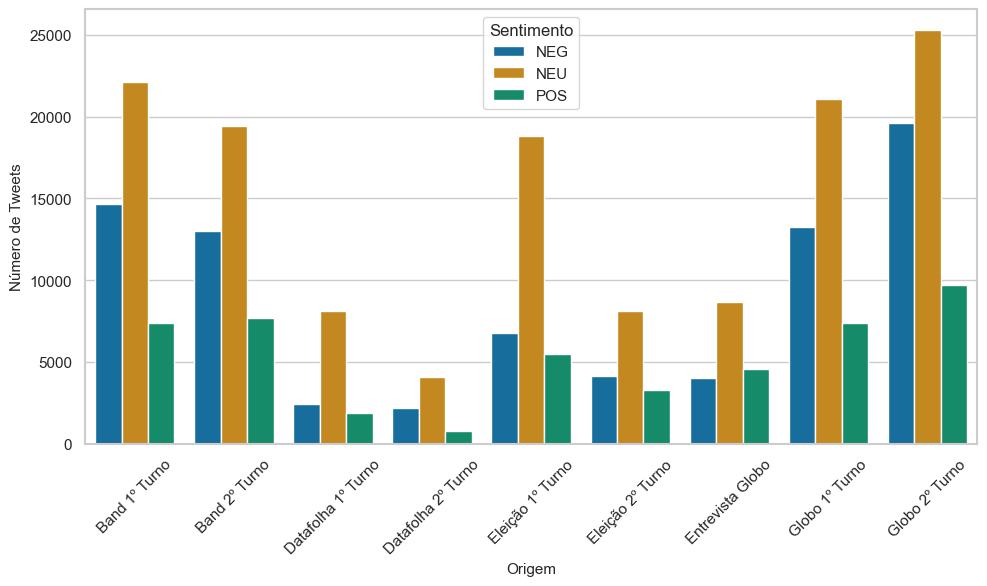

In [72]:
# Setting up the style for the plots
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Arial'

# Creating the plot for Lula's sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=lula_sentiment_distribution.reset_index().melt(id_vars='origin'), x='origin', y='value', hue='pysentimiento_Sentiment', palette='colorblind')
plt.xlabel('Origem', fontsize=11)  # Translated to Brazilian Portuguese
plt.ylabel('Número de Tweets', fontsize=11)  # Translated to Brazilian Portuguese
plt.xticks(rotation=45)
plt.legend(title='Sentimento')  # Translated to Brazilian Portuguese
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
# Save the plot as an image file
plt.savefig('/content/drive/Path/To/Data/Lula_Sentiment_Distribution.jpg', dpi=600)

plt.show()

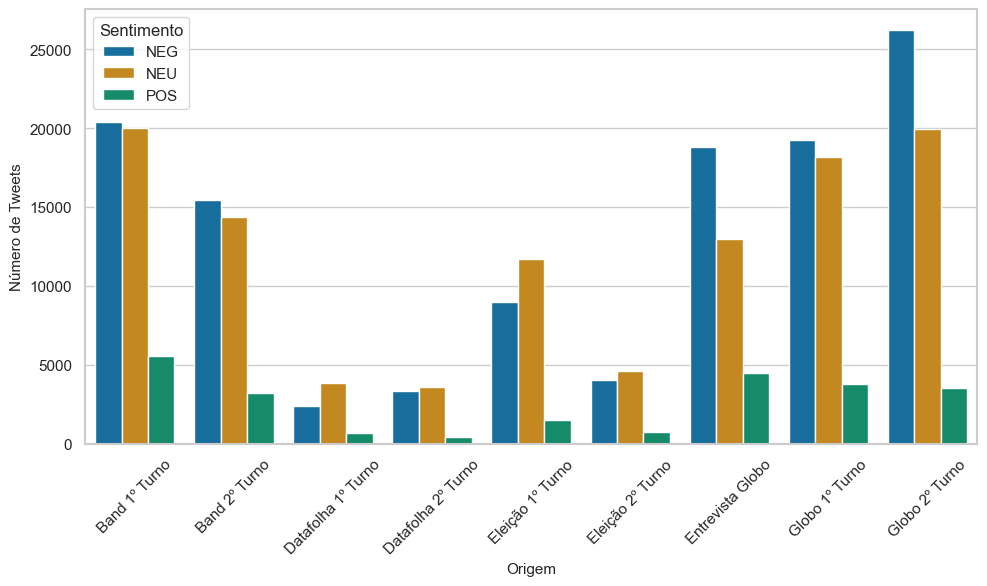

In [73]:
# Assuming bolsonaro_sentiment_distribution is already calculated
plt.figure(figsize=(10, 6))
sns.barplot(data=bolsonaro_sentiment_distribution.reset_index().melt(id_vars='origin'),
            x='origin', y='value', hue='pysentimiento_Sentiment', palette='colorblind')
plt.xlabel('Origem', fontsize=11)  # Translated to Brazilian Portuguese
plt.ylabel('Número de Tweets', fontsize=11)  # Translated to Brazilian Portuguese
plt.xticks(rotation=45)
plt.legend(title='Sentimento')  # Translated to Brazilian Portuguese
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
# Save the plot as an image file
plt.savefig('/content/drive/Path/To/Data/Bolsonaro_Sentiment_Distribution.jpg', dpi=600)

In [74]:
# Calculate sentiment distribution for Lula and Bolsonaro
sentiment_distribution_lula = lula_data['pysentimiento_Sentiment'].value_counts(normalize=True) * 100
sentiment_distribution_bolsonaro = bolsonaro_data['pysentimiento_Sentiment'].value_counts(normalize=True) * 100

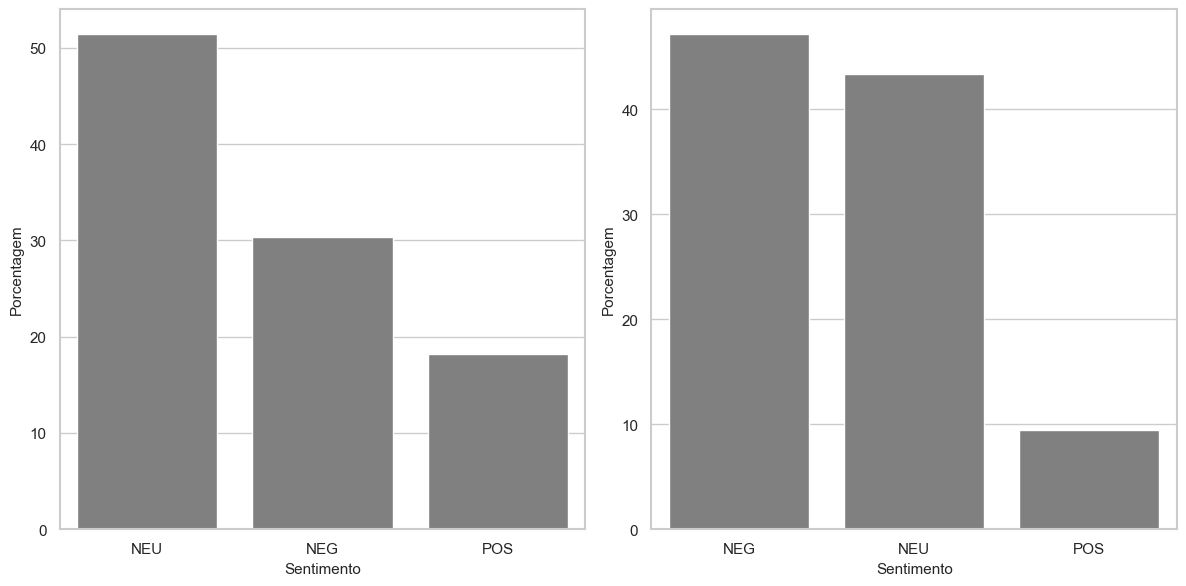

In [75]:
# Assuming sentiment_distribution_lula and sentiment_distribution_bolsonaro are calculated
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Lula's Sentiment Distribution
sns.barplot(x=sentiment_distribution_lula.index, y=sentiment_distribution_lula.values, ax=ax[0], color='grey')
ax[0].set_ylabel('Porcentagem', fontsize=11)  # Translated to Brazilian Portuguese
ax[0].set_xlabel('Sentimento', fontsize=11)  # Translated to Brazilian Portuguese
ax[0].spines['top'].set_linewidth(1.5)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['left'].set_linewidth(1.5)
ax[0].spines['right'].set_linewidth(1.5)

# Bolsonaro's Sentiment Distribution
sns.barplot(x=sentiment_distribution_bolsonaro.index, y=sentiment_distribution_bolsonaro.values, ax=ax[1], color='grey')
ax[1].set_ylabel('Porcentagem', fontsize=11)  # Translated to Brazilian Portuguese
ax[1].set_xlabel('Sentimento', fontsize=11)  # Translated to Brazilian Portuguese
ax[1].spines['top'].set_linewidth(1.5)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].spines['right'].set_linewidth(1.5)

plt.tight_layout()
# Save the plot as an image file
plt.savefig('/content/drive/Path/To/Data/Comparative_Sentiment_Lula.jpg', dpi=600)
plt.savefig('/content/drive/Path/To/DataComparative_Sentiment_Bolsonaro.jpg', dpi=600)

### 2.1.1 Sentiment Distribution by date

In [76]:
# Filter the data for the candidates Lula and Bolsonaro
lula_data = df[df['Lula'] == True]
bolsonaro_data = df[df['Bolsonaro'] == True]

In [77]:
# Group by date and sentiment
lula_grouped = lula_data.groupby([lula_data['Time'].dt.date, 'pysentimiento_Sentiment']).size().unstack(fill_value=0)
bolsonaro_grouped = bolsonaro_data.groupby([bolsonaro_data['Time'].dt.date, 'pysentimiento_Sentiment']).size().unstack(fill_value=0)

In [80]:
def fix_time_columns(df):
    df['Time'] = df['Time'].astype(str)  # Convert to string
    df['Time'] = pd.to_datetime(df['Time'].str.split(' ').str[0], format='%Y-%m-%d')
    return df

lula_data = fix_time_columns(lula_data.copy())  # Create a copy to avoid modification in-place
bolsonaro_data = fix_time_columns(bolsonaro_data.copy())

In [81]:
# Group by date and sentiment
lula_grouped = lula_data.groupby([lula_data['Time'].dt.date, 'pysentimiento_Sentiment']).size().unstack(fill_value=0)
bolsonaro_grouped = bolsonaro_data.groupby([bolsonaro_data['Time'].dt.date, 'pysentimiento_Sentiment']).size().unstack(fill_value=0)

In [82]:
# Set other plot configurations
plt.rcParams['font.size'] = 11

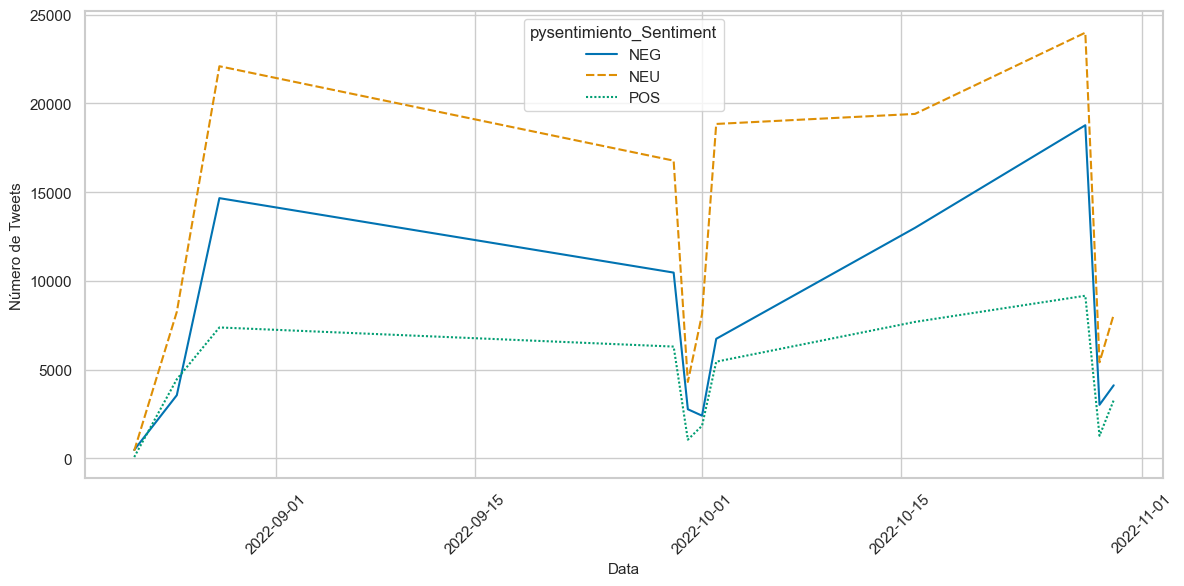

In [83]:
# Assuming lula_grouped dataset is prepared
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility

# Lula
sns.lineplot(data=lula_grouped, palette='colorblind')
plt.xlabel('Data', fontsize=11)  # Translated to Brazilian Portuguese
plt.ylabel('Número de Tweets', fontsize=11)  # Translated to Brazilian Portuguese
plt.xticks(rotation=45)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
# Save the plot as an image file
plt.savefig('/content/drive/Path/To/Data/Lula_Sentiment_Over_Time.jpg', dpi=600)


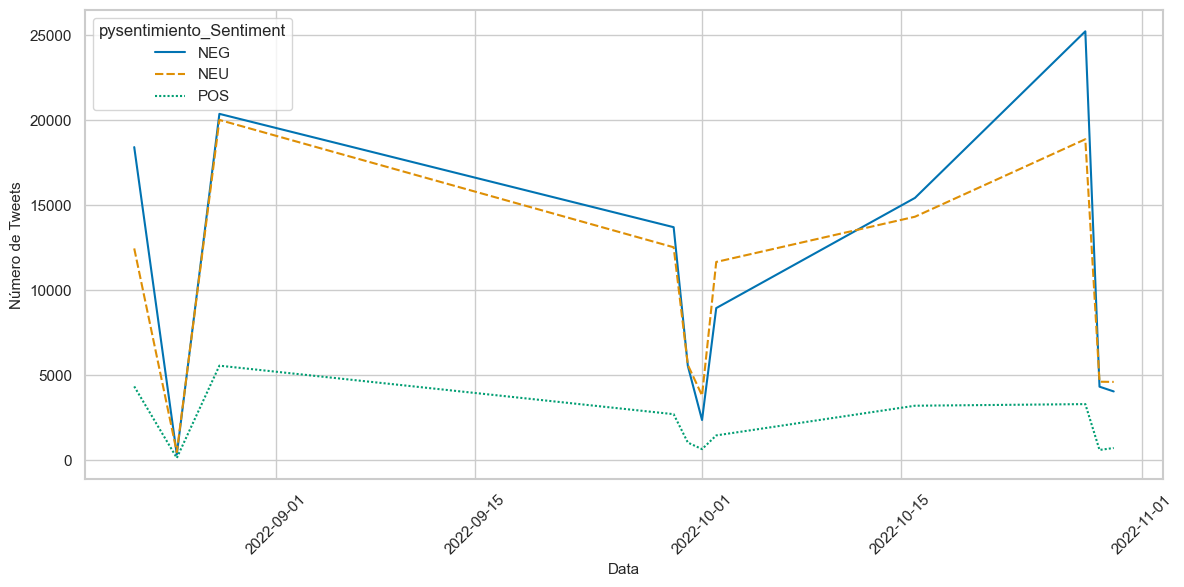

In [84]:
# Bolsonaro
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
sns.lineplot(data=bolsonaro_grouped, palette='colorblind')
plt.xlabel('Data', fontsize=11)  # Translated to Brazilian Portuguese
plt.ylabel('Número de Tweets', fontsize=11)  # Translated to Brazilian Portuguese
plt.xticks(rotation=45)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
# Save the plot as an image file
plt.savefig('/content/drive/Path/To/DataBolsonaro_Sentiment_Over_Time.jpg', dpi=600)

## 2.2 Word Cloud

In [85]:
# Define stopwords including the candidate names in various forms
stopwords = set(["Lula", "lula", "Bolsonaro", "bolsonaro", "JAIR", "jair", "LUIZ", "luiz"] + list(WordCloud().stopwords))

In [86]:
def generate_word_cloud(candidate, sentiment):
    # Filter data for the specified candidate and sentiment 
    filtered_data = df[(df[candidate] == True) & (df['pysentimiento_Sentiment'] == sentiment)]

    # Combine all tweets into a single string 
    text = " ".join(tweet for tweet in filtered_data['Tweet'])

    # Generate word cloud 
    wordcloud = WordCloud(width=800, height=800, background_color='white',
                          stopwords=stopwords, min_font_size=10).generate(text) 

    # Plotting the WordCloud 
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    # Save the word cloud
# Save the plot as an image file
    plt.savefig(f'/content/drive/Path/To/Data/{candidate}_Sentiment_{sentiment}.jpg', dpi=600)

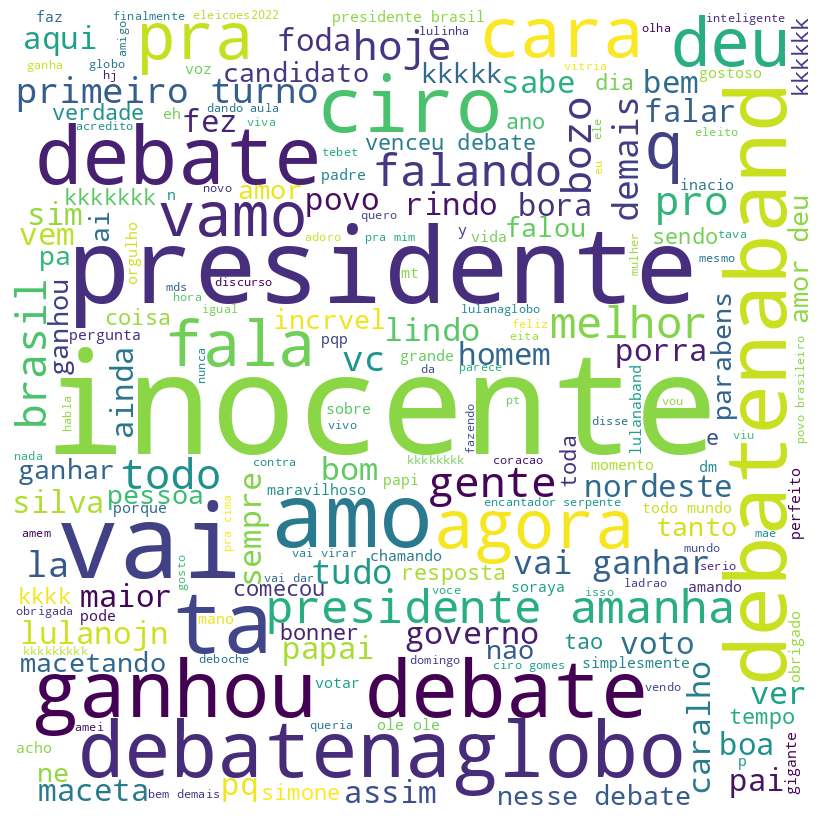

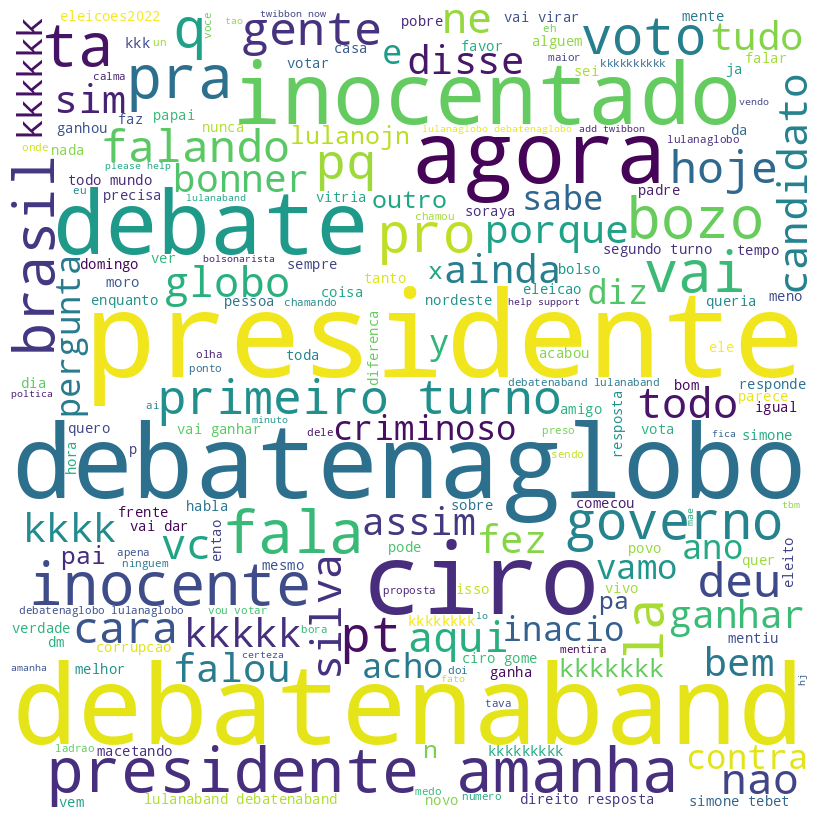

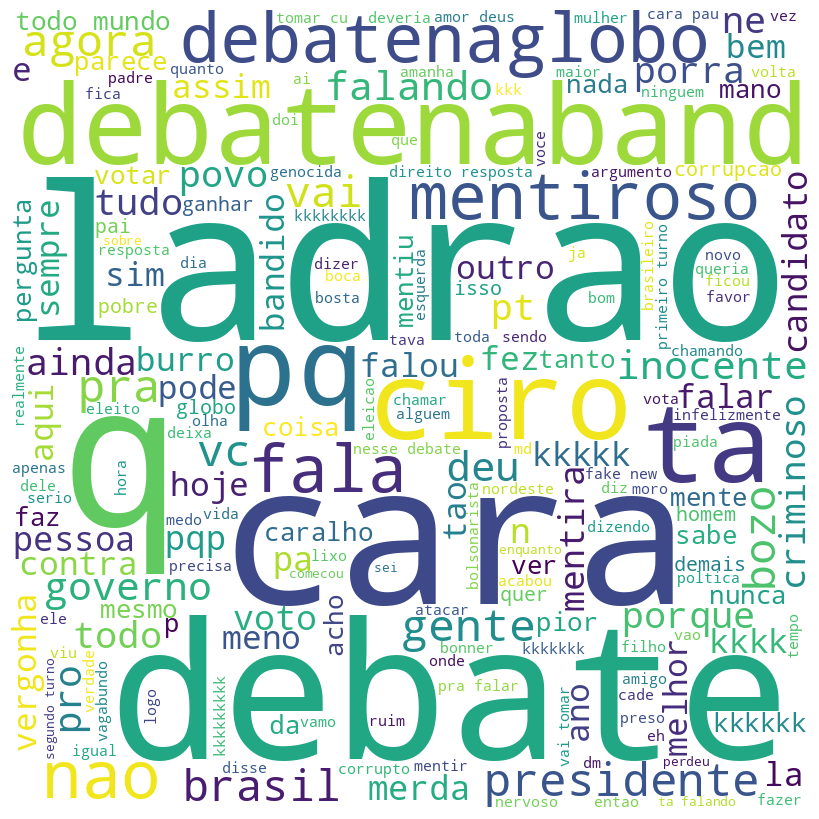

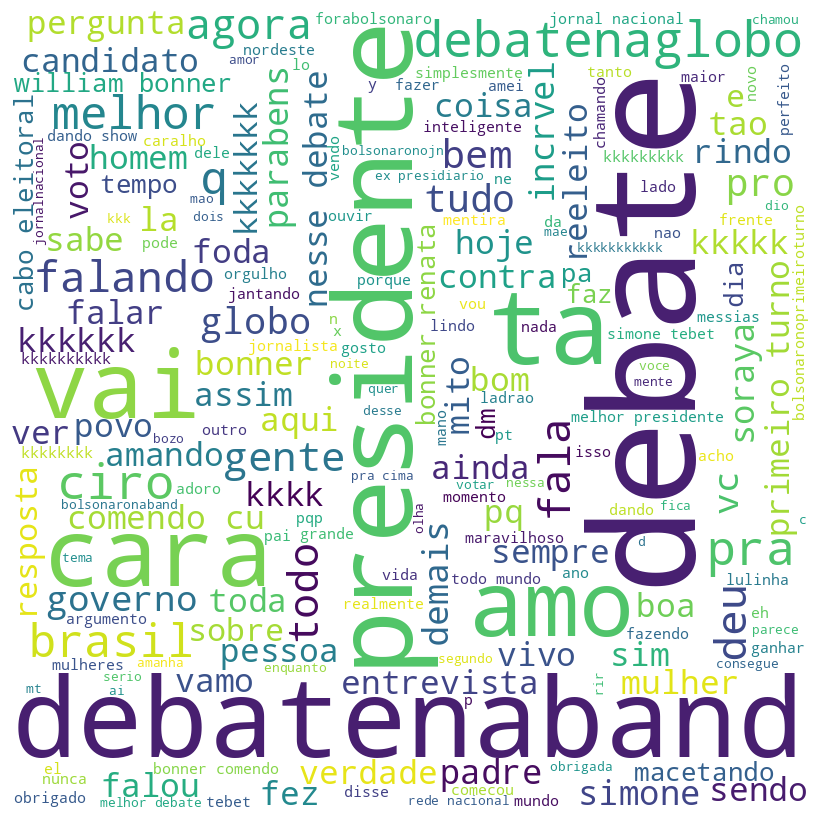

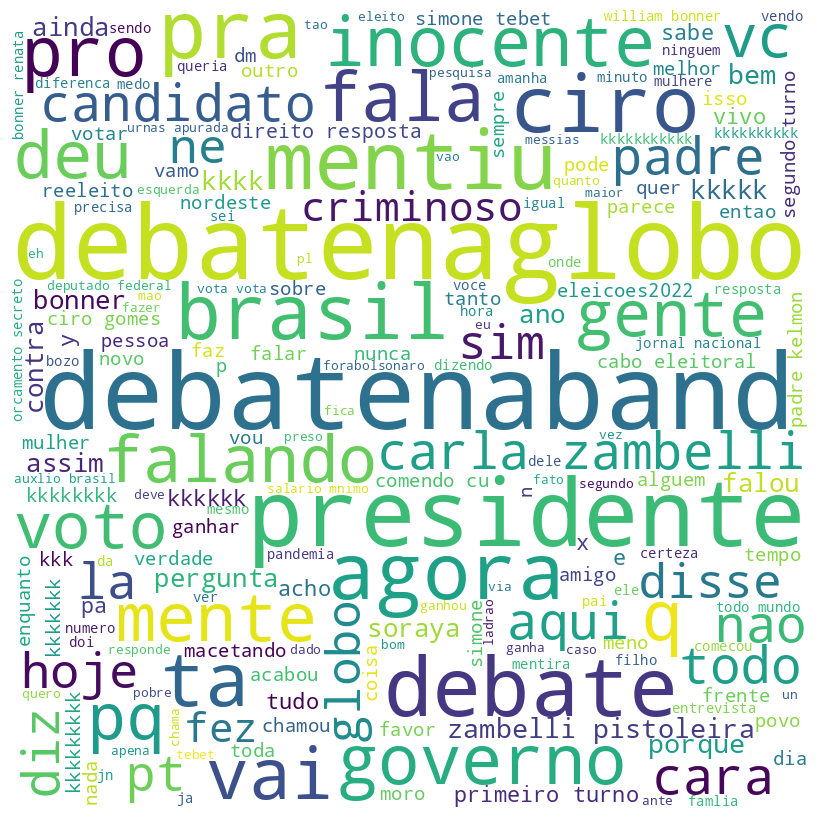

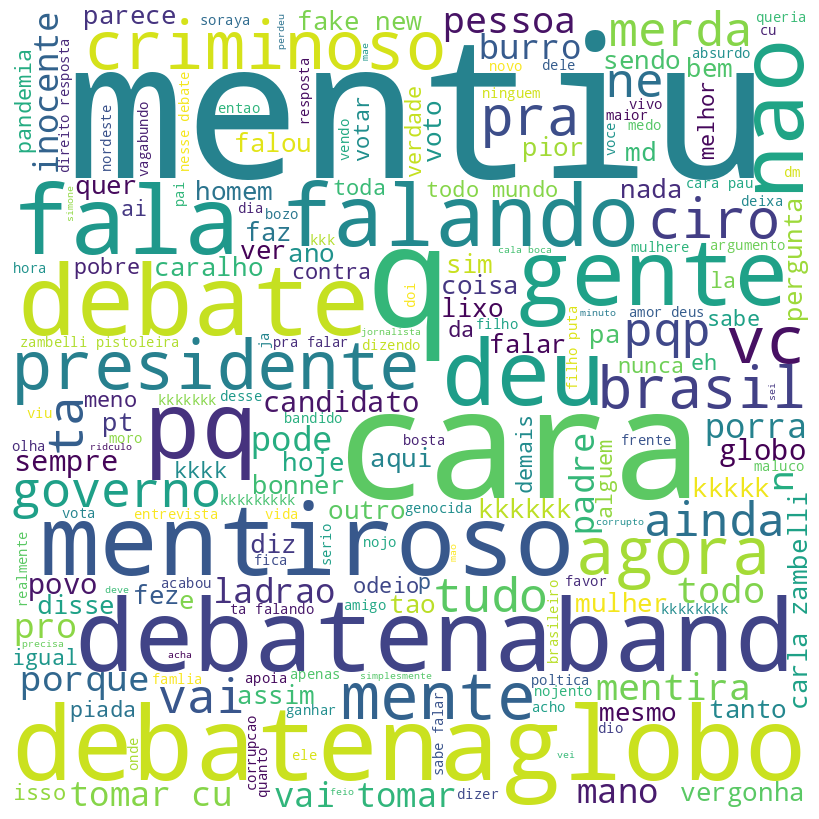

In [87]:
for candidate in ['Lula', 'Bolsonaro']:
    for sentiment in ['POS', 'NEU', 'NEG']:
        generate_word_cloud(candidate, sentiment)

## 2.3 Bubble Graph

In [11]:
# Import necessary libraries
import plotly.express as px

In [28]:
lula_data = df[df['Lula'] == True]
bolsonaro_data = df[df['Bolsonaro'] == True]

In [26]:
grouped_data_lula = lula_data.groupby('User').agg(
    avg_followers_count=('Followers_Count', 'mean'),
    tweet_count=('ID', 'count'),
    predominant_sentiment=('pysentimiento_Sentiment', lambda x: x.mode()[0])  # most frequent sentiment
).reset_index()

In [39]:
jpg_filename = '/content/drive/Path/To/Data/sentiment_analysis_graph.jpg'

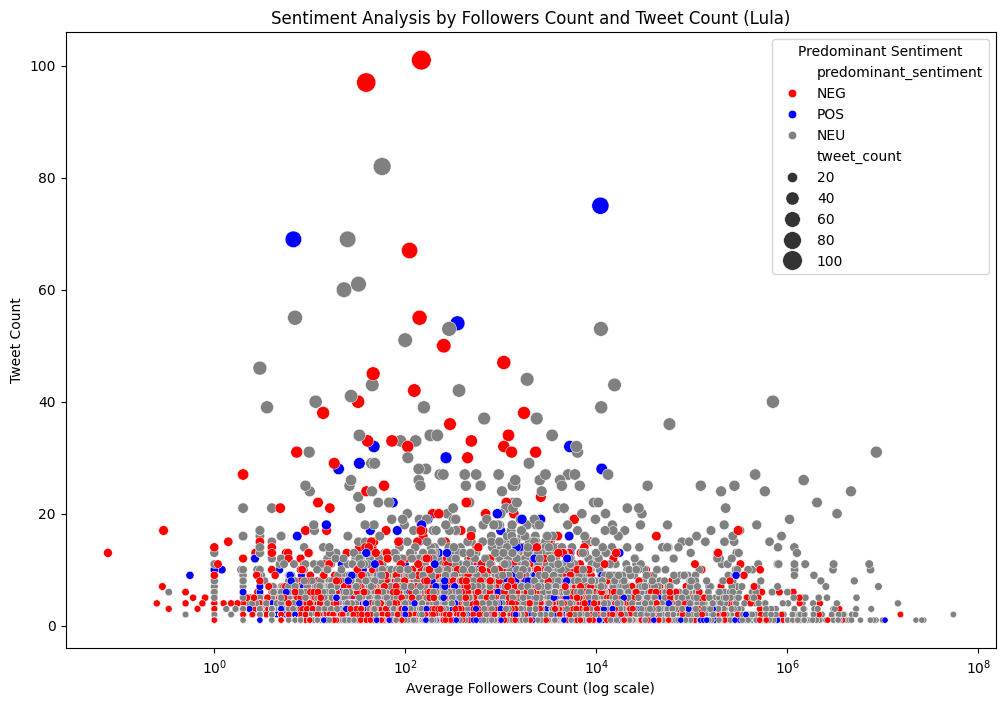

In [41]:
# Creating the bubble graphs
plt.figure(figsize=(12, 8))
sns.scatterplot(data=grouped_data_lula, x="avg_followers_count", y="tweet_count", size="tweet_count", 
                sizes=(20, 200), hue="predominant_sentiment", palette=color_map)
plt.xscale('log')  # using a logarithmic scale for better visualization of a wide range of follower counts
plt.title("Sentiment Analysis by Followers Count and Tweet Count (Lula)")
plt.xlabel("Average Followers Count (log scale)")
plt.ylabel("Tweet Count")
plt.legend(title='Predominant Sentiment', loc='upper right')
# Save the plot as an image file
plt.savefig(jpg_filename, format='jpg', dpi=600)
plt.show()

In [29]:
grouped_data_bolsonaro = bolsonaro_data.groupby('User').agg(
    avg_followers_count=('Followers_Count', 'mean'),
    tweet_count=('ID', 'count'),
    predominant_sentiment=('pysentimiento_Sentiment', lambda x: x.mode()[0])  # most frequent sentiment
).reset_index()

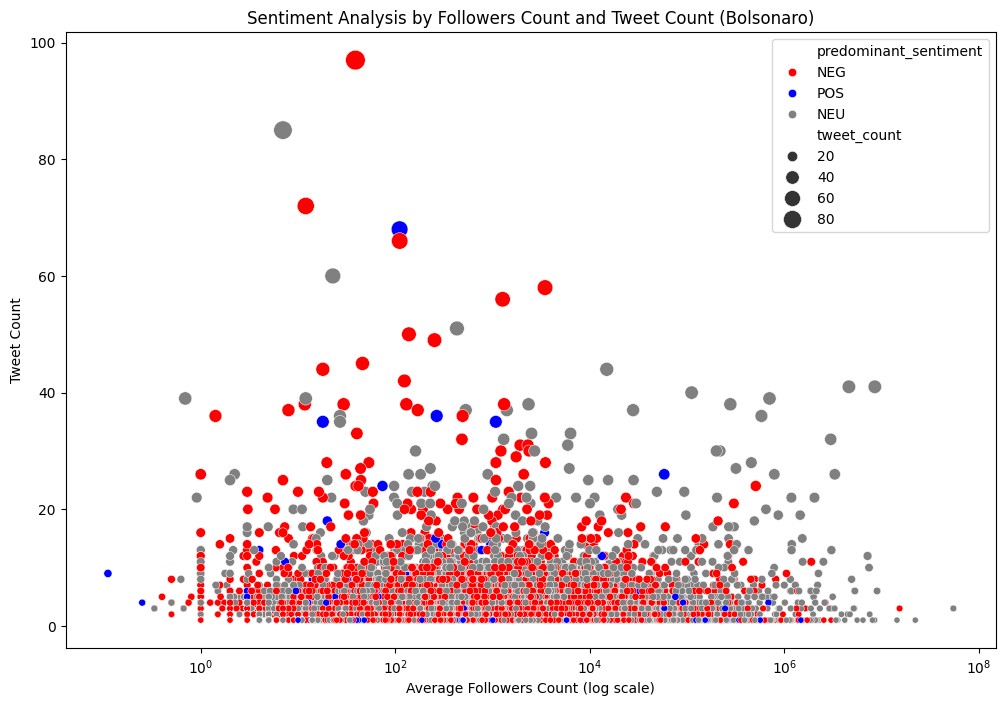

In [42]:
# Creating the bubble graphs
plt.figure(figsize=(12, 8))
sns.scatterplot(data=grouped_data_bolsonaro, x="avg_followers_count", y="tweet_count", size="tweet_count", 
                sizes=(20, 200), hue="predominant_sentiment", palette=color_map)
plt.xscale('log')  # using a logarithmic scale for better visualization of a wide range of follower counts
plt.title("Sentiment Analysis by Followers Count and Tweet Count (Bolsonaro)")
plt.xlabel("Average Followers Count (log scale)")
plt.ylabel("Tweet Count")
plt.legend(loc='upper right')
# Save the plot as an image file
plt.savefig(f'/content/drive/Path/To/Data/bubble_bolsonaro.jpg', dpi=600)
plt.show()

## 2.4 Statistical Analysis

In [53]:
# Calculate account age at the time of the tweet in days
df['Account_Age'] = (df['Time'] - df['Created_at']).dt.days

In [54]:
# Convert sentiments to numerical scores
sentiment_scores = {'NEG': -1, 'NEU': 0, 'POS': 1}
df['Sentiment_score'] = df['pysentimiento_Sentiment'].map(sentiment_scores)

In [55]:
# Grouping data by User and Candidate to calculate the average sentiment, average followers count, tweet count
# We'll do this for Lula and Bolsonaro separately

# Filtering for Lula and Bolsonaro
lula_tweets = df[df['Lula'] == True]
bolsonaro_tweets = df[df['Bolsonaro'] == True]

In [56]:
# Aggregating data for Lula
grouped_lula = lula_tweets.groupby('User_ID').agg(
    avg_sentiment_score=('Sentiment_score', 'mean'),
    avg_followers_count=('Followers_Count', 'mean'),
    tweet_count=('ID', 'count'),
    avg_account_age=('Account_Age', 'mean')
).reset_index()

In [57]:
# Aggregating data for Bolsonaro
grouped_bolsonaro = bolsonaro_tweets.groupby('User_ID').agg(
    avg_sentiment_score=('Sentiment_score', 'mean'),
    avg_followers_count=('Followers_Count', 'mean'),
    tweet_count=('ID', 'count'),
    avg_account_age=('Account_Age', 'mean')
).reset_index()

In [58]:
grouped_lula.head(), grouped_bolsonaro.head()

(       User_ID  avg_sentiment_score  avg_followers_count  tweet_count  \
 0  1,15051E+18                  1.0                 29.0            1   
 1  1,17374E+18                  0.0                 32.0            1   
 2  1,26068E+18                  0.0                 55.0            1   
 3  1,35678E+18                 -1.0                 23.0            1   
 4  1,36626E+18                 -1.0                367.0            1   
 
    avg_account_age  
 0           1176.0  
 1           1111.0  
 2            872.0  
 3            606.0  
 4            580.0  ,
        User_ID  avg_sentiment_score  avg_followers_count  tweet_count  \
 0  1,00033E+18                  0.0                257.0            1   
 1  1,25556E+18                  0.0                249.0            1   
 2   1,3409E+18                  0.0                328.0            1   
 3  1,45591E+18                  0.0                640.0            1   
 4  1,54841E+18                 -1.0               

In [61]:
# calculate the correlation matrix for both aggregated datasets
correlation_matrix_lula_agg = grouped_lula[['avg_followers_count', 'avg_sentiment_score', 'avg_account_age', 'tweet_count']].corr()
correlation_matrix_bolsonaro_agg = grouped_bolsonaro[['avg_followers_count', 'avg_sentiment_score', 'avg_account_age', 'tweet_count']].corr()

correlation_matrix_lula_agg

,avg_followers_count,avg_sentiment_score,avg_account_age,tweet_count
avg_followers_count,1.000000,0.002358,0.031785,0.026963
avg_sentiment_score,0.002358,1.000000,0.006717,-0.004619
avg_account_age,0.031785,0.006717,1.000000,0.030755
tweet_count,0.026963,-0.004619,0.030755,1.000000


In [62]:
correlation_matrix_bolsonaro_agg

,avg_followers_count,avg_sentiment_score,avg_account_age,tweet_count
avg_followers_count,1.000000,0.008123,0.034569,0.041893
avg_sentiment_score,0.008123,1.000000,-0.012720,0.001338
avg_account_age,0.034569,-0.012720,1.000000,0.040427
tweet_count,0.041893,0.001338,0.040427,1.000000


**Summary**


### Lula:
- `avg_followers_count` and `avg_sentiment_score` show an extremely weak positive correlation (0.0024), suggesting there is no meaningful relationship between the number of followers and the sentiment of tweets.
- `avg_followers_count` and `avg_account_age` have a weak positive correlation (0.0318), hinting that users with older accounts might have a marginally higher number of followers.
- `avg_followers_count` and `tweet_count` also have a weak positive correlation (0.0270), suggesting that users with more followers tend to have a slightly higher tweet count.
- `avg_sentiment_score` and `avg_account_age` show a very weak positive correlation (0.0067), indicating almost no relationship between account age and tweet sentiment.
- `avg_sentiment_score` and `tweet_count` show a negligible negative correlation (-0.0046), suggesting no meaningful relationship between the sentiment and the number of tweets.
- `avg_account_age` and `tweet_count` have a weak positive correlation (0.0308), which may suggest that slightly older accounts are more active in terms of tweet count.

### Bolsonaro:
- `avg_followers_count` and `avg_sentiment_score` exhibit an extremely weak positive correlation (0.0081), which indicates that there is no significant relationship between the number of followers and tweet sentiment.
- `avg_followers_count` and `avg_account_age` show a weak positive correlation (0.0346), implying that older accounts might have a slightly higher number of followers.
- `avg_followers_count` and `tweet_count` display a weak positive correlation (0.0419), indicating that users with more followers might tweet slightly more.
- `avg_sentiment_score` and `avg_account_age` show a very weak negative correlation (-0.0127), suggesting almost no relationship between account age and tweet sentiment.
- `avg_sentiment_score` and `tweet_count` have an extremely weak positive correlation (0.0013), indicating no significant relationship.
- `avg_account_age` and `tweet_count` have a weak positive correlation (0.0404), which could suggest that slightly older accounts are a bit more active in terms of tweeting.

In both cases, the correlations are quite weak, meaning that there are no strong linear relationships between the variables analyzed. It's important to consider that correlation does not imply causation, and these relationships are merely descriptive of this particular dataset.